# Project in Machine Learning Class: Predict user's review sentiment

### John Koumentis, MTN2012

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns

import string
import re

import nltk
nltk.download('words')
from nltk.classify import textcat
nltk.download('crubadan')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package crubadan to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package crubadan is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load and pre-process data

The data used comes from the 'Amazon Cell Phones Reviews' dataset found in Kaggle (https://www.kaggle.com/grikomsn/amazon-cell-phones-reviews)

In [2]:
#Read the reviews dataset

df = pd.read_csv('20191226-reviews.csv')
df = df.drop('name', axis=1)

In [3]:
#Check for missing data
missing_data = df.isnull().sum()
print(missing_data)

asin                0
rating              0
date                0
verified            0
title              14
body               21
helpfulVotes    40771
dtype: int64


In [4]:
#Remove empty reviews
empty_reviews = np.where(pd.isnull(df.body))
df.drop(list(empty_reviews)[0],inplace=True)
empty_reviews

(array([ 9445, 18055, 19749, 20892, 21149, 21887, 22917, 29501, 30010,
        35596, 36845, 43415, 45899, 46470, 51628, 52176, 55171, 57837,
        61074, 62205, 64371], dtype=int64),)

In [5]:
df.head(10)

,asin,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0
5,B0000SX2UC,4,"September 25, 2005",False,Worked great for me,"Hello, I have this phone and used it until I d...",NaN
6,B0000SX2UC,5,"April 16, 2004",False,Wanna cool Nokia? You have it here!,Cool. Cheap. Color: 3 words that describe the ...,2.0
7,B0000SX2UC,4,"April 3, 2004",False,Problem with 3588i universal headset,"The 3599i is overall a nice phone, except that...",2.0
8,B0000SX2UC,5,"November 24, 2003",False,cool phone!!!!!!!!,"I've never owned a Nokia phone before, so this...",7.0
9,B0000SX2UC,3,"February 2, 2004",False,Pissed off-a little bit,ok well im in school and i need the text messa...,3.0


In [6]:
#Isolate body and rating columns in a new dataset
reviews_dataset = pd.DataFrame({'reviews':df.body.values, 'ratings':df.rating.values})
#reviews_dataset.to_csv('reviews.csv')
reviews_dataset.head()

,reviews,ratings
0,I had the Samsung A600 for awhile which is abs...,3
1,Due to a software issue between Nokia and Spri...,1
2,"This is a great, reliable phone. I also purcha...",5
3,"I love the phone and all, because I really did...",3
4,The phone has been great for every purpose it ...,4


After removing the lines containing the empty reviews and creating a new dataset by keeping only the reviews and ratings column, the reviews column was loaded in XLSX format at https://translate.google.gr/?hl=el&sl=auto&tl=el&op=docs and translated. The output was an HTML table that was launched via Excel and stored in CSV format with name 'translate.csv'.

In [7]:
translated = pd.read_csv('translate.csv',header=None)
reviews_dataset.insert(loc=1, column='greek', value=translated)
reviews_dataset.head(10)

,reviews,greek,ratings
0,I had the Samsung A600 for awhile which is abs...,Είχα το Samsung A600 για λίγο που είναι απόλυτ...,3
1,Due to a software issue between Nokia and Spri...,Λόγω ενός προβλήματος λογισμικού μεταξύ της No...,1
2,"This is a great, reliable phone. I also purcha...","Αυτό είναι ένα υπέροχο, αξιόπιστο τηλέφωνο. Αγ...",5
3,"I love the phone and all, because I really did...","Λατρεύω το τηλέφωνο και όλα, γιατί πραγματικά ...",3
4,The phone has been great for every purpose it ...,Το τηλέφωνο ήταν τέλειο για κάθε σκοπό που προ...,4
5,"Hello, I have this phone and used it until I d...","Γεια σας, έχω αυτό το τηλέφωνο και το χρησιμοπ...",4
6,Cool. Cheap. Color: 3 words that describe the ...,Δροσερός. Φτηνός. Χρώμα: 3 λέξεις που περιγράφ...,5
7,"The 3599i is overall a nice phone, except that...","Το 3599i είναι γενικά ένα ωραίο τηλέφωνο, εκτό...",4
8,"I've never owned a Nokia phone before, so this...","Δεν είχα ποτέ προηγουμένως τηλέφωνο Nokia, γι ...",5
9,ok well im in school and i need the text messa...,"εντάξει, είμαι στο σχολείο και χρειάζομαι τα γ...",3


In [8]:
#Clean reviews text
lemma = WordNetLemmatizer()
punctuation = set(string.punctuation)

def clean_text(text):
    # Convert the text into lowercase
    text = text.lower()
    # Split into list
    wordList = text.split()
    # Remove punctuation
    wordList = ["".join(x for x in word if (x=="'")|(x not in punctuation)) for word in wordList]
    # Remove stopwords
    wordList = [word for word in wordList if word not in stopwords.words('english')]
    # Lemmatisation
    wordList = [lemma.lemmatize(word) for word in wordList]
    return " ".join(wordList)

In [9]:
#reviews_dataset['cleaned_text'] = reviews_dataset['reviews'].apply(clean_text)

C:\Users\John\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ratings', ylabel='count'>

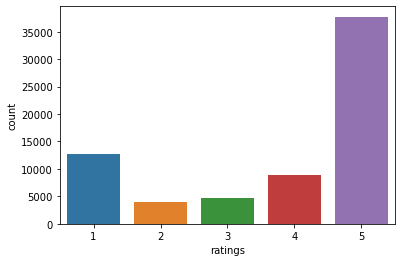

In [10]:
# Check the ratings count

sns.countplot(reviews_dataset['ratings'])

The `4` and `5` star (positive) ratings combined are more than the `1`,`2` ones (negative) combined. Hence, I decided to add the `3` star ratings to the negative ratings. In order to simplify the situation, I replaced the `4`,`5` star ratings with the label `1`, to indicate positive sentiment and the `1`,`2`,`3` star ratings with the label `0`, to indicate negative sentiment.

In [11]:
sentiment_dict = {1:0, 2:0, 3:0, 4:1, 5:1}
reviews_dataset['ratings'].replace(sentiment_dict,inplace=True)
reviews_dataset.head(10)

,reviews,greek,ratings
0,I had the Samsung A600 for awhile which is abs...,Είχα το Samsung A600 για λίγο που είναι απόλυτ...,0
1,Due to a software issue between Nokia and Spri...,Λόγω ενός προβλήματος λογισμικού μεταξύ της No...,0
2,"This is a great, reliable phone. I also purcha...","Αυτό είναι ένα υπέροχο, αξιόπιστο τηλέφωνο. Αγ...",1
3,"I love the phone and all, because I really did...","Λατρεύω το τηλέφωνο και όλα, γιατί πραγματικά ...",0
4,The phone has been great for every purpose it ...,Το τηλέφωνο ήταν τέλειο για κάθε σκοπό που προ...,1
5,"Hello, I have this phone and used it until I d...","Γεια σας, έχω αυτό το τηλέφωνο και το χρησιμοπ...",1
6,Cool. Cheap. Color: 3 words that describe the ...,Δροσερός. Φτηνός. Χρώμα: 3 λέξεις που περιγράφ...,1
7,"The 3599i is overall a nice phone, except that...","Το 3599i είναι γενικά ένα ωραίο τηλέφωνο, εκτό...",1
8,"I've never owned a Nokia phone before, so this...","Δεν είχα ποτέ προηγουμένως τηλέφωνο Nokia, γι ...",1
9,ok well im in school and i need the text messa...,"εντάξει, είμαι στο σχολείο και χρειάζομαι τα γ...",0


C:\Users\John\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ratings', ylabel='count'>

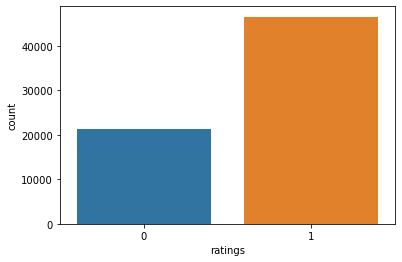

In [12]:
sns.countplot(reviews_dataset['ratings'])

In [13]:
reviews = reviews_dataset.reviews
translated_reviews = reviews_dataset.greek
labels = reviews_dataset.ratings
print('Orginal review text:\n\n{}\n\nand it\'s greek translation:\n\n{}'.format(reviews[0],translated_reviews[0]))

Orginal review text:

I had the Samsung A600 for awhile which is absolute doo doo. You can read my review on it and detect my rage at the stupid thing. It finally died on me so I used this Nokia phone I bought in a garage sale for $1. I wonder y she sold it so cheap?... Bad: ===> I hate the menu. It takes forever to get to what you want because you have to scroll endlessly. Usually phones have numbered categories so u can simply press the # and get where you want to go. ===> It's a pain to put it on silent or vibrate. If you're in class and it rings, you have to turn it off immediately. There's no fast way to silence the damn thing. Always remember to put it on silent! I learned that the hard way. ===> It's so true about the case. It's a mission to get off and will break ur nails in the process. Also, you'll damage the case each time u try. For some reason the phone started giving me problems once I did succeed in opening it. ===> Buttons could be a bit bigger. Vibration could be stron

## Check Positive and Negative usage of words

In [14]:
# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

In [15]:
# Loop over all the words in all the reviews and increment the counts in the appropriate counter objects
for i in range(len(reviews)):
    for word in translated_reviews[i].split(" "):
        total_counts[word] += 1
        if labels[i] == 1:
            positive_counts[word] += 1
        else:
            negative_counts[word] += 1
        

In [16]:
pos_neg_ratios = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(total_counts.most_common()):
    if(cnt > 100):
        pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio
        
# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)

In [17]:
print("Pos-to-neg ratio for 'το' = {}".format(pos_neg_ratios["το"]))
print("Pos-to-neg ratio for 'υπέροχο' = {}".format(pos_neg_ratios["υπέροχο"]))
print("Pos-to-neg ratio for 'απογοητευμένος' = {}".format(pos_neg_ratios["απογοητευμένος"]))

Pos-to-neg ratio for 'το' = 0.4645098993220195
Pos-to-neg ratio for 'υπέροχο' = 1.600240818953183
Pos-to-neg ratio for 'απογοητευμένος' = -1.4737366797236018


Neutral words like 'το' have logarithmic pos-to-neg ratio slightly larger than zero. Positive words like 'υπέροχο' logarithmic ratio is larger than `1`, that means it is used mostly in positive reviews, whereas negative words like 'απογοητευμένος' have a ratio value smaller than `-1` indicating that they are used mostly in negative reviews.

In [18]:
#list(pos_neg_ratios.most_common())[0:40]

In [19]:
#list(reversed(pos_neg_ratios.most_common()))[0:40]

In [20]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))

In [21]:
tfidf.fit_transform(reviews)

<67965x35305 sparse matrix of type '<class 'numpy.float64'>'
	with 1570495 stored elements in Compressed Sparse Row format>

In [22]:
vocab = set(nltk.corpus.words.words())

## Machine Learning Pipeline

In [23]:
X = reviews_dataset['greek']
y = reviews_dataset['ratings']

In [24]:
def model_training(X,y,algorithm):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

    model_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', algorithm),
    ])

    # Feed the training data through the pipeline
    model_clf.fit(X_train, y_train) 

    # Form a prediction set
    predictions = model_clf.predict(X_test)

    # Report the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_test,predictions)
    print('Confusion Matrix\n{}\n'.format(confusion_matrix))

    # Create a classification report
    report = metrics.classification_report(y_test,predictions)
    print('Classification report\n{}\n'.format(report))

    # Calculate the overall accuracy
    accuracy_score = metrics.accuracy_score(y_test,predictions)
    print('Overall accuracy: {}'.format(accuracy_score))
    
    return model_clf

### Naive Bayes algorithm

In [25]:
nb = MultinomialNB()

In [26]:
text_nb = model_training(X,y,nb)

Confusion Matrix
[[ 3278  3078]
 [  266 13768]]

Classification report
              precision    recall  f1-score   support

           0       0.92      0.52      0.66      6356
           1       0.82      0.98      0.89     14034

    accuracy                           0.84     20390
   macro avg       0.87      0.75      0.78     20390
weighted avg       0.85      0.84      0.82     20390


Overall accuracy: 0.8359980382540461


### Support Vector Machines algorithm

In [27]:
svm = LinearSVC()

In [28]:
text_svm = model_training(X,y,svm)

Confusion Matrix
[[ 5133  1223]
 [  951 13083]]

Classification report
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      6356
           1       0.91      0.93      0.92     14034

    accuracy                           0.89     20390
   macro avg       0.88      0.87      0.87     20390
weighted avg       0.89      0.89      0.89     20390


Overall accuracy: 0.893379107405591


#### Check prediction in review from https://www.skroutz.gr/s/20060269/Apple-iPhone-11-64GB-Black.html

In [29]:
greek_review = 'Κατοχος περιπου 7 χρονια iphone, πιστευω πως ειναι το καλυτερο iphone που εχω παρει ποτε,\
σε μεγεθος ειναι ο,τι πρεπει, και η μπαταρια του πολυ καλη, ειχα πετυχει μεχρι και δυο 24ωρα\
διαρκεια μπαταριας στις αρχες που το ειχα παρει, θα μεινω αρκετο καιρο μ αυτο το κινητο απ οτι βλεπω...'

print('Naive Bayes prediction: {}\nSVM prediction: {}'.format(text_nb.predict([greek_review]),
      text_svm.predict([greek_review])))

Naive Bayes prediction: [1]
SVM prediction: [1]


In [30]:
r = text_svm[0].transform([reviews[0]])

In [31]:
r.data

array([0.22755037, 0.03480314, 0.03528271, 0.03583633, 0.03832571,
       0.07056541, 0.03832571, 0.03480314, 0.03729252, 0.03729252,
       0.06509109, 0.03305948, 0.07665141, 0.03729252, 0.0397819 ,
       0.03583633, 0.03071096, 0.0397819 , 0.02982438, 0.03729252,
       0.0397819 , 0.03649112, 0.03583633, 0.36554824, 0.03231376,
       0.06267426, 0.07458504, 0.0397819 , 0.03583633, 0.36389957,
       0.03231376, 0.03832571, 0.03832571, 0.03832571, 0.02023591,
       0.03649112, 0.19675996, 0.0795638 , 0.03832571, 0.03528271,
       0.03279333, 0.07665141, 0.02756678, 0.02558428, 0.03649112,
       0.03729252, 0.03365944, 0.0397819 , 0.0397819 , 0.03832571,
       0.0397819 , 0.03169657, 0.03832571, 0.0397819 , 0.07665141,
       0.03649112, 0.03832571, 0.03729252, 0.0397819 , 0.03334695,
       0.03832571, 0.06202083, 0.14001867, 0.03832571, 0.03085757,
       0.03528271, 0.03400174, 0.03528271, 0.10351521, 0.06960628,
       0.0397819 , 0.05688759, 0.02930297, 0.01704923, 0.02027